## FIN3080 Assignment 4

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Individual stock return data preprocessing

In [4]:
""" Step 1.1 """

# Read the data
def read_stock_data():
    return_df = pd.DataFrame()
    for i in range(1, 10):
        file_name = 'data/Daily Stock Price Returns/TRD_Dalyr_' + str(i) + '.csv'
        file_df = pd.read_csv(file_name)
        return_df = pd.concat([return_df, file_df], ignore_index=True)
    return return_df

return_df = read_stock_data()

In [5]:
""" Step 1.2 """
return_df.columns = ['code', 'date', 'return']
return_df['date'] = pd.to_datetime(return_df['date'], format='%Y-%m-%d')

### Step 2: Market return data preprocessing

In [6]:
""" Step 2.1 """
market_df = pd.read_csv('data/Daily Market Returns/TRD_Dalym.csv')
market_df.columns = ['type', 'date', 'return']

""" Step 2.2 """
market_df = market_df[market_df['type'] == 1]

""" Step 2.3 """
market_df['date'] = pd.to_datetime(market_df['date'], format='%Y-%m-%d')
market_df.drop(columns=['type'], inplace=True)

### Step 3: EPS data preprocessing

In [7]:
""" Step 3.1 """
eps_df = pd.read_csv("data/Index per Share/FI_T9.csv")
eps_df.columns = ['code', 'name', 'date', 'type', 'industry_code', 'eps']

""" Step 3.2 """
eps_df = eps_df[eps_df['type'] == 'A']
eps_df.drop(columns=['type'], inplace=True)

In [8]:
""" Step 3.3 """
# exclude name start with ST, PT, *ST, SST, S*ST
probelm_firms = eps_df[(eps_df['name'].str.startswith('ST')) | 
                       (eps_df['name'].str.startswith('PT')) | 
                       (eps_df['name'].str.startswith('*ST')) |
                       (eps_df['name'].str.startswith('SST')) |
                       (eps_df['name'].str.startswith('S*ST'))]

# get the code of the probelm firms
probelm_firms_code = probelm_firms['code'].unique()

# only keep the firms that are not in the probelm firms
eps_df = eps_df[~eps_df['code'].isin(probelm_firms_code)]

In [9]:
""" Step 3.4 """
eps_df = eps_df[~eps_df['industry_code'].str.startswith('J')]
eps_df.drop(columns=['industry_code'], inplace=True)

""" Step 3.5 """
eps_df['date'] = pd.to_datetime(eps_df['date'], format='%Y-%m-%d')
eps_df = eps_df[(eps_df['date'].dt.month == 6) | (eps_df['date'].dt.month == 12)]

""" Step 3.6 """
eps_df['date'] = eps_df['date'].dt.to_period('H')
eps_df['year'] = eps_df['date'].dt.year

In [10]:
""" Step 3.7 & 3.8 """
def update_eps(group):
    june_eps = group[group['date'].dt.month == 6][['year', 'eps']].reset_index(drop=True)
    june_eps.rename(columns={'eps': 'june_eps'}, inplace=True)

    dec_eps = group[group['date'].dt.month == 12][['year', 'date', 'eps']].reset_index(drop=True)
    dec_eps.rename(columns={'eps': 'dec_eps'}, inplace=True)

    new_eps = pd.merge(june_eps, dec_eps, on='year', how='outer')
    new_eps['dec_eps'] = new_eps['dec_eps'] - new_eps['june_eps']
    new_eps.rename(columns={'dec_eps': 'new_eps'}, inplace=True)

    group = pd.merge(group, new_eps[['date', 'new_eps']], on='date', how='left')
    group.loc[group['date'].dt.month == 12, 'eps'] = group.loc[group['date'].dt.month == 12, 'new_eps']
    group.drop(columns=['new_eps'], inplace=True)
    return group

eps_df = eps_df.groupby('code').apply(update_eps)
eps_df.dropna(subset=['eps'], inplace=True)
eps_df.reset_index(drop=True, inplace=True)

In [11]:
""" Step 3.9 """
def get_ue(group):
    group['ue'] = group['eps'] - group['eps'].shift(2)
    return group

eps_df = eps_df.groupby('code').apply(get_ue)
eps_df.reset_index(drop=True, inplace=True)

In [12]:
""" Step 3.10 """
def standardize_ue(group):
    group['rolling_std'] = group['ue'].rolling(window=4).std()
    group['sue'] = group['ue'] / group['rolling_std']
    return group

eps_df = eps_df.groupby('code').apply(standardize_ue)
eps_df.dropna(subset=['sue'], inplace=True)
eps_df.reset_index(drop=True, inplace=True)

In [13]:
""" Step 3.11 """
# Derive SUE deciles for each firm by each date
eps_df['sue_decile'] = eps_df.groupby('date')['sue'].transform(lambda x: pd.qcut(x, 10, labels=False))

""" Step 3.12 """
eps_df = eps_df.loc[:, ['code', 'date', 'sue_decile']]

In [14]:
""" Step 3.13 """
eps_df = eps_df.pivot(index='code', columns='date', values='sue_decile')
eps_df.reset_index(drop=False, inplace=True)
eps_df

date,code,2016-12-31 00:00,2017-06-30 00:00,2017-12-31 00:00,2018-06-30 00:00,2018-12-31 00:00,2019-06-30 00:00,2019-12-31 00:00,2020-06-30 00:00,2020-12-31 00:00,2021-06-30 00:00,2021-12-31 00:00,2022-06-30 00:00,2022-12-31 00:00
0,2,7.0,8.0,9.0,9.0,9.0,9.0,4.0,4.0,7.0,1.0,0.0,6.0,4.0
1,6,8.0,6.0,3.0,7.0,4.0,0.0,6.0,6.0,4.0,9.0,1.0,3.0,6.0
2,8,9.0,4.0,7.0,4.0,1.0,4.0,5.0,2.0,0.0,4.0,1.0,6.0,8.0
3,9,1.0,3.0,3.0,4.0,9.0,7.0,2.0,4.0,8.0,8.0,5.0,4.0,9.0
4,11,8.0,9.0,3.0,1.0,7.0,4.0,6.0,8.0,2.0,9.0,3.0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3930,873167,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,5.0
3931,873169,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,7.0,1.0
3932,873223,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,5.0,1.0
3933,873305,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,4.0,3.0


### Step 4: Announcement data preprocessing

In [15]:
""" Step 4.1 """
announce_df = pd.read_csv('data/Statements Release Dates/IAR_Rept.csv')
announce_df.columns = ['code', 'name', 'type', 'report_date', 'announce_date']

""" Step 4.2 """
announce_df = announce_df[(announce_df['type'] == 2) | (announce_df['type'] == 4)]
announce_df.drop(columns=['type'], inplace=True)
announce_df.dropna(subset=['announce_date'], inplace=True)

In [16]:
""" Step 4.3 """
# reshape the “long” data set into a “wide” data set
announce_df['announce_date'] = pd.to_datetime(announce_df['announce_date'], format='%Y-%m-%d')
announce_df['report_date'] = pd.to_datetime(announce_df['report_date'], format='%Y-%m-%d').dt.to_period('H')
announce_df = announce_df.pivot(index='code', columns='report_date', values='announce_date')
announce_df.reset_index(drop=False, inplace=True)
announce_df

report_date,code,2016-06-30 00:00,2016-12-31 00:00,2017-06-30 00:00,2017-12-31 00:00,2018-06-30 00:00,2018-12-31 00:00,2019-06-30 00:00,2019-12-31 00:00,2020-06-30 00:00,2020-12-31 00:00,2021-06-30 00:00,2021-12-31 00:00,2022-06-30 00:00,2022-12-31 00:00
0,1,2016-08-12,2017-03-17,2017-08-11,2018-03-15,2018-08-16,2019-03-07,2019-08-08,2020-02-14,2020-08-28,2021-02-02,2021-08-20,2022-03-10,2022-08-18,2023-03-09
1,2,2016-08-22,2017-03-27,2017-08-25,2018-03-27,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
2,4,2016-08-31,2017-04-11,2017-08-31,2018-04-28,2018-08-25,2019-04-26,2019-08-31,2020-04-28,2020-08-31,2021-04-28,2021-08-27,2022-04-30,2022-08-25,2023-04-29
3,5,2016-08-25,2017-04-27,2017-08-26,2018-04-21,2018-08-30,2019-04-25,2019-08-29,2020-05-23,2020-08-29,2021-04-30,2021-08-27,2022-04-27,2022-08-27,2023-04-29
4,6,2016-08-19,2017-03-30,2017-08-18,2018-03-30,2018-08-17,2019-03-30,2019-08-16,2020-04-09,2020-08-28,2021-03-31,2021-08-27,2022-04-16,2022-08-25,2023-04-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5244,873223,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2022-08-25,2023-04-26
5245,873305,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-26
5246,873339,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
5247,873527,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-17


### Step 5: Data merging

In [17]:
""" Step 5.1 & 5.2 """
df = pd.merge(return_df, market_df, on='date', how='left')
df.rename(columns={'return_x': 'stock_return', 'return_y': 'market_return'}, inplace=True)

In [18]:
""" Step 5.3 & 5.4 """
df = pd.merge(df, eps_df, on='code', how='right')
df = pd.merge(df, announce_df, on='code', how='left')

# drop and rename columns
df.columns = df.columns[:4].tolist() + ['sue_decile_' + str(i) for i in range(1, 14)] + df.columns[17:].tolist()
df.drop(columns=df.columns[17], inplace=True)
df.columns = df.columns[:17].tolist() + ['ann_date_' + str(i) for i in range(1, 14)] + df.columns[30:].tolist()
df

,code,date,stock_return,market_return,sue_decile_1,sue_decile_2,sue_decile_3,sue_decile_4,sue_decile_5,sue_decile_6,...,ann_date_4,ann_date_5,ann_date_6,ann_date_7,ann_date_8,ann_date_9,ann_date_10,ann_date_11,ann_date_12,ann_date_13
0,2,2016-07-04,-0.099877,0.022721,7.0,8.0,9.0,9.0,9.0,9.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
1,2,2016-07-05,-0.100045,0.009576,7.0,8.0,9.0,9.0,9.0,9.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
2,2,2016-07-06,0.000505,0.008418,7.0,8.0,9.0,9.0,9.0,9.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
3,2,2016-07-07,-0.049495,0.002856,7.0,8.0,9.0,9.0,9.0,9.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
4,2,2016-07-08,-0.003719,-0.003644,7.0,8.0,9.0,9.0,9.0,9.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149819,873339,2023-12-25,0.057292,-0.004500,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149820,873339,2023-12-26,0.001642,-0.009787,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149821,873339,2023-12-27,-0.008197,0.007200,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149822,873339,2023-12-28,0.074380,0.015103,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12


### Step 6: Event study

In [19]:
""" Step 6.1 """
whole_study_df = df.copy()

""" Step 6.2 """
whole_study_df['ab_return'] = whole_study_df['stock_return'] - df['market_return']
whole_study_df.drop(columns=['stock_return', 'market_return'], inplace=True)
cols = whole_study_df.columns.tolist()
cols = cols[:2] + cols[-1:] + cols[2:-1]
whole_study_df = whole_study_df[cols]
whole_study_df

,code,date,ab_return,sue_decile_1,sue_decile_2,sue_decile_3,sue_decile_4,sue_decile_5,sue_decile_6,sue_decile_7,...,ann_date_4,ann_date_5,ann_date_6,ann_date_7,ann_date_8,ann_date_9,ann_date_10,ann_date_11,ann_date_12,ann_date_13
0,2,2016-07-04,-0.122598,7.0,8.0,9.0,9.0,9.0,9.0,4.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
1,2,2016-07-05,-0.109621,7.0,8.0,9.0,9.0,9.0,9.0,4.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
2,2,2016-07-06,-0.007913,7.0,8.0,9.0,9.0,9.0,9.0,4.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
3,2,2016-07-07,-0.052351,7.0,8.0,9.0,9.0,9.0,9.0,4.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
4,2,2016-07-08,-0.000075,7.0,8.0,9.0,9.0,9.0,9.0,4.0,...,2018-08-21,2019-03-26,2019-08-21,2020-03-18,2020-08-28,2021-03-31,2021-08-30,2022-03-31,2022-08-31,2023-03-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6149819,873339,2023-12-25,0.061792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149820,873339,2023-12-26,0.011429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149821,873339,2023-12-27,-0.015397,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12
6149822,873339,2023-12-28,0.059277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2023-04-12


In [20]:
""" Step 6.3 """

for i in range(1, 14):
    # Select the columns needed for the study iteration
    columns_to_select = ['code', 'date', 'ab_return', f'sue_decile_{i}', f'ann_date_{i}']
    study_df = whole_study_df[columns_to_select].copy()

    # Calculate the date difference between the announcement date and each day
    study_df['date_diff'] = (study_df['date'] - study_df[f'ann_date_{i}']).dt.days
    study_df = study_df[study_df['date_diff'].abs() <= 100]

    # Calculate the event date
    for stock in study_df['code'].unique():
        stock_df = study_df[study_df['code'] == stock]
        nearest_event_row = stock_df['date_diff'].abs().idxmin()
        study_df.loc[stock_df.index, 'event_date'] = stock_df.index - nearest_event_row

    # Filter the useful event date data
    study_df = study_df[study_df['event_date'].abs() <= 60]

    # Filter the data with correct length
    for stock in study_df['code'].unique():
        stock_df = study_df[study_df['code'] == stock]
        if stock_df.shape[0] != 121:
            study_df = study_df.drop(stock_df.index)

    # Calculate the average abnormal return for each decile
    study_df.dropna(inplace=True)
    study_df = study_df.groupby([f'sue_decile_{i}', 'event_date'])['ab_return'].mean().reset_index()

    # for each group of sue_decile, calculate cumulative sums of abnormal returns from -60 to 60
    study_df['cum_ab_return'] = study_df.groupby([f'sue_decile_{i}'])['ab_return'].cumsum()
    study_df.drop(columns=['ab_return'], inplace=True)

    # store the data in study_result
    if i == 1:
        study_result = study_df
        study_result.columns = ['sue_decile', 'event_date', f'portfolio_car_{i}']
    else:
        study_result = pd.concat([study_result, study_df['cum_ab_return']], axis=1)
        study_result.columns = study_result.columns[:(i+1)].tolist() + [f'portfolio_car_{i}']

study_result

,sue_decile,event_date,portfolio_car_1,portfolio_car_2,portfolio_car_3,portfolio_car_4,portfolio_car_5,portfolio_car_6,portfolio_car_7,portfolio_car_8,portfolio_car_9,portfolio_car_10,portfolio_car_11,portfolio_car_12,portfolio_car_13
0,0.0,-60.0,-0.004390,0.000485,-0.000290,-0.001467,-0.001238,-0.000075,-0.002838,0.000626,-0.002648,-0.001063,-0.002450,-0.000593,0.003179
1,0.0,-59.0,-0.005509,0.002987,0.000384,-0.003914,-0.007244,0.001327,-0.003506,0.002147,-0.005248,-0.001015,-0.008370,0.000015,0.005319
2,0.0,-58.0,-0.006409,0.002141,0.000747,-0.006923,-0.014252,0.002535,0.001985,0.004160,-0.011430,-0.004972,-0.009343,-0.002739,0.009870
3,0.0,-57.0,-0.008055,0.001010,0.001666,-0.007092,-0.024489,0.002455,0.002742,0.002068,-0.017032,-0.004797,-0.013830,-0.004181,0.012770
4,0.0,-56.0,-0.007269,0.001007,-0.002241,-0.008308,-0.028339,0.003472,0.004910,0.001530,-0.023588,-0.005610,-0.016933,-0.004855,0.015269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1205,9.0,56.0,-0.032862,-0.018674,0.074163,0.028191,0.061950,0.096952,0.107442,0.088084,-0.013640,0.101245,0.028113,0.043344,0.025285
1206,9.0,57.0,-0.032695,-0.017711,0.075549,0.028866,0.063001,0.095141,0.110147,0.084546,-0.010885,0.100040,0.029635,0.039508,0.025038
1207,9.0,58.0,-0.034611,-0.020726,0.076219,0.026777,0.063310,0.095296,0.108677,0.083363,-0.010946,0.101751,0.028964,0.037257,0.022401
1208,9.0,59.0,-0.033896,-0.019241,0.077664,0.027763,0.063792,0.095006,0.107771,0.082884,-0.008107,0.105935,0.029287,0.035888,0.018249


In [21]:
""" Step 6.4 """
final_mean_result = study_result.copy()
final_mean_result['mean_portfolio_car'] = final_mean_result.iloc[:, 2:].mean(axis=1)
final_mean_result = final_mean_result[['sue_decile', 'event_date', 'mean_portfolio_car']]
final_mean_result['sue_decile'] = final_mean_result['sue_decile'] + 1

final_mean_result

,sue_decile,event_date,mean_portfolio_car
0,1.0,-60.0,-0.000982
1,1.0,-59.0,-0.001741
2,1.0,-58.0,-0.002664
3,1.0,-57.0,-0.004367
4,1.0,-56.0,-0.005458
...,...,...,...
1205,10.0,56.0,0.045353
1206,10.0,57.0,0.045398
1207,10.0,58.0,0.044441
1208,10.0,59.0,0.044846


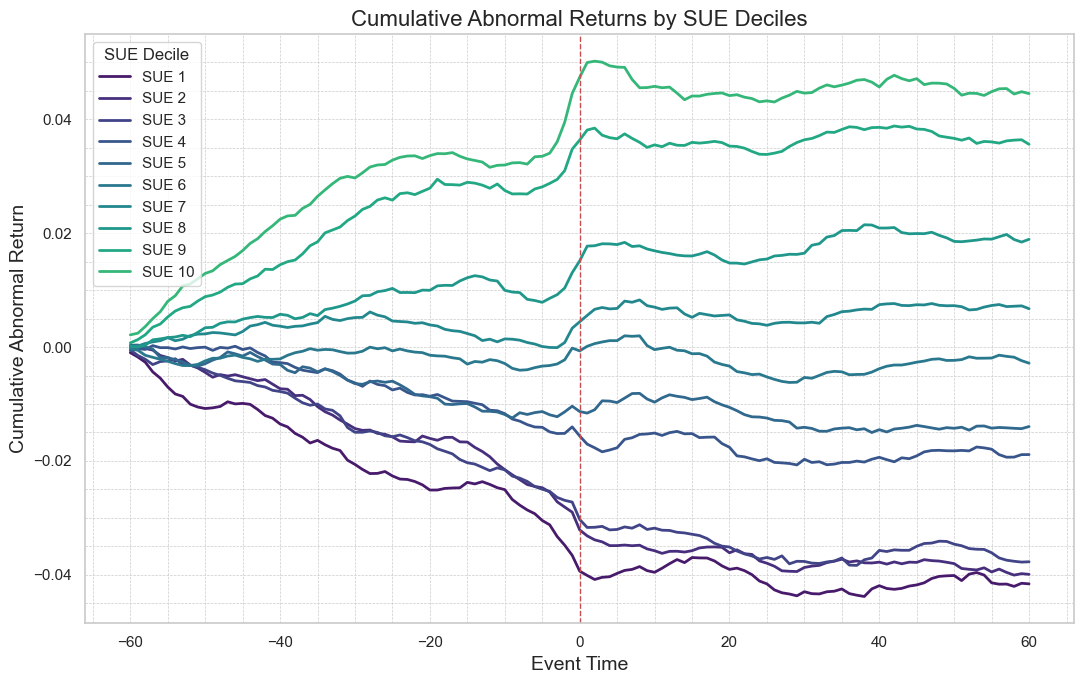

In [22]:
""" Step 6.5 """

# Set the style of seaborn
sns.set(style='whitegrid')

# Create a color palette
palette = sns.color_palette("viridis", n_colors=14)

# Set the plot size
plt.figure(figsize=(11, 7))

# Plot each decile
for i, decile in enumerate(sorted(final_mean_result['sue_decile'].unique()), start=1):
    subset = final_mean_result[final_mean_result['sue_decile'] == decile]
    plt.plot(subset['event_date'], subset['mean_portfolio_car'], label=f'SUE {int(decile)}', linewidth=2, color=palette[i-1])

# Customizing the plot with titles and labels
plt.title('Cumulative Abnormal Returns by SUE Deciles', fontsize=16)
plt.xlabel('Event Time', fontsize=14)
plt.ylabel('Cumulative Abnormal Return', fontsize=14)

# Draw a vertical line at event_date 0 and style it
plt.axvline(x=0, color='r', linestyle='--', linewidth=1)

# Legend
plt.legend(title='SUE Decile', loc='upper left', frameon=True, framealpha=0.8, facecolor='white')

# Enhance grid visibility and aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

# Show the plot
plt.tight_layout()
plt.savefig('output/Result Figure.png', dpi=300)
plt.show()